<div style="text-align:center">
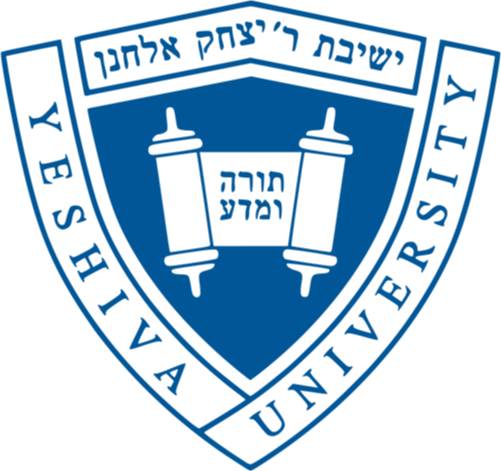
</div>

<br><br>
<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5001 Data Acquisition & Management</h1>
<p>
<h2 style='text-align: center;'>Assignment M13</h1>
<h2 style='text-align: center;'>PostgreSQL to Neo4j Data Migration</h1>
<br><br>

<h3 style='text-align: center;'>Sheng-Han Yueh</h3>
<h3 style='text-align: center;'>Radek Jan Holik</h3>
<h3 style='text-align: center;'>Chi-Kuang Chen</h3>
<br>
<br>

In [1]:
import psycopg2
import os

# 1) Introduction
__The aim of this assignment is to transfer a relational database from PostgreSQL into a graph database. We copy the tables from the Chinkook database in Postgres into csv files and import them into neo4j. After creating the nodes and relationships, we can query data from a graph database.__

# 2) PostgreSQL to Neo4j Migration

__The following command in Postgres is exporting tables into csv files__ 

COPY "Album" TO 'D:\Album.csv' DELIMITER ',' CSV HEADER;<br>
COPY "Artist" TO 'D:\Artist.csv' DELIMITER ',' CSV HEADER;<br> 
COPY "Genre" TO 'D:\Genre.csv' DELIMITER ',' CSV HEADER;<br>
COPY "MediaType" TO 'D:\MediaType.csv' DELIMITER ',' CSV HEADER;<br>
COPY "Track" TO 'D:\Track.csv' DELIMITER ',' CSV HEADER;  

In [2]:
# Login details to the local postgreSQL server
conn = psycopg2.connect(
    host = "localhost",
    database="chinook",
    user = "postgres",
    password = "admin")

# Create a cursor object
cursor = conn.cursor()

In [3]:
# Current work directory
cwd = os.getcwd()
cwd.replace('\\','/')

'c:/New Volume/Documents/yu/AIM 5001 Data Acquisition & Management/HW/M13'

In [4]:
# Creation of "CSV_Files" directory
try:
    os.mkdir(f"{cwd}/CSV_Files")
except FileExistsError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'c:\\New Volume\\Documents\\yu\\AIM 5001 Data Acquisition & Management\\HW\\M13/CSV_Files'


In [5]:
sqlQuery =f'''COPY "Album" TO '{cwd}/CSV_Files/Album.csv' DELIMITER ',' CSV HEADER;'''
cursor.execute(sqlQuery)
conn.commit()

sqlQuery =f'''COPY "Artist" TO '{cwd}/CSV_Files/Artist.csv' DELIMITER ',' CSV HEADER;'''
cursor.execute(sqlQuery)
conn.commit()

sqlQuery =f'''COPY "Genre" TO '{cwd}/CSV_Files/Genre.csv' DELIMITER ',' CSV HEADER;'''
cursor.execute(sqlQuery)
conn.commit()

sqlQuery =f'''COPY "MediaType" TO '{cwd}/CSV_Files/MediaType.csv' DELIMITER ',' CSV HEADER;'''
cursor.execute(sqlQuery)
conn.commit()

sqlQuery =f'''COPY "Track" TO '{cwd}/CSV_Files/Track.csv' DELIMITER ',' CSV HEADER;'''
cursor.execute(sqlQuery)
conn.commit()

In [6]:
# Closing the connection
conn.close()

__The primary key in 5 tables become node, and other attributes becomes to properties of that node. The relationships are created by the foreign keys. The relationships in this database are as the following.__   

__1. Artist -produce-> Album : though the pair of ArtistId in Artist and Album table__  
__2. Album -including_tracks-> Track: through the pair of AlbumId in Album and Track table__  
__3. Genre -categorized_as_genre-> Track : though the pair of GenreId in Track and Genre table__  
__4. MediaType -categorized_as_mediatype-> Track : through the pair of MediaTypeId in Track and MediaType table__

<center>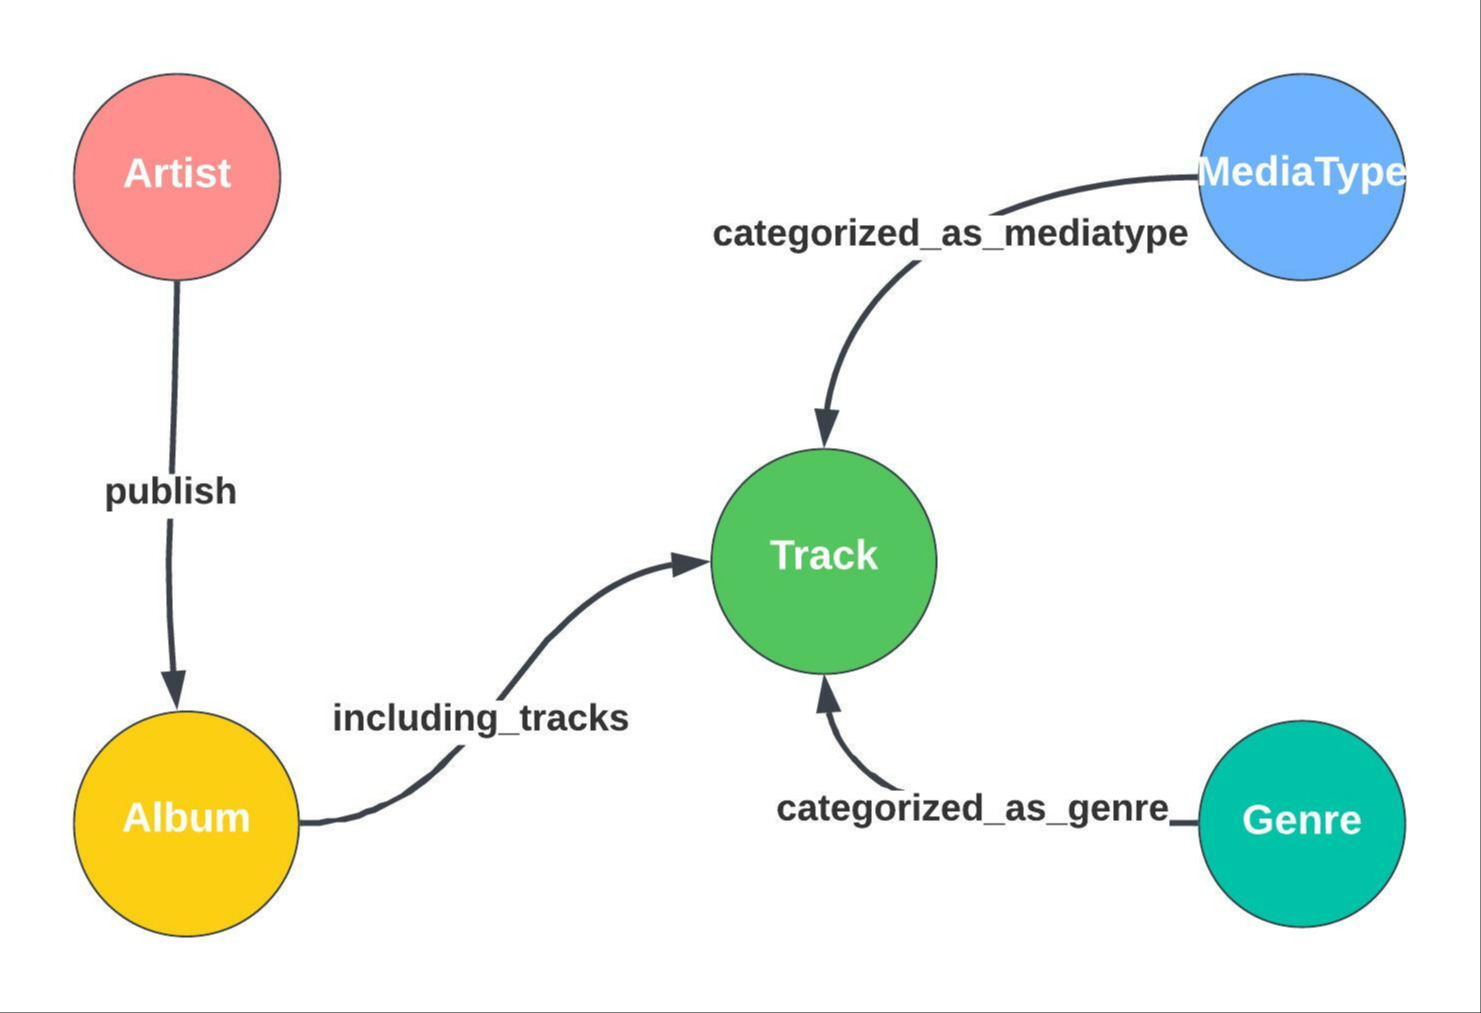</center>

__Loading csv files into Neoj4__
* __1. copy csv files in local folders__
* __2. execute the following codes in neo4j browser to create nodes, labels, and properties. Add constraints for primary key in each table__

LOAD CSV WITH HEADERS FROM 'file:///Artist.csv' AS Ar  
CREATE (ArI:Artist {ID: Ar.ArtistId, Name: Ar.Name});  
CREATE CONSTRAINT FOR (ArI:Artist) REQUIRE ArI.ID IS UNIQUE;  

LOAD CSV WITH HEADERS FROM 'file:///Album.csv' AS Al  
CREATE (AlI:Album {ID: Al.AlbumId, Name: Al.Title, ArId:Al.ArtistId});   
CREATE CONSTRAINT FOR (AlI:Album) REQUIRE AlI.ID IS UNIQUE;

LOAD CSV WITH HEADERS FROM 'file:///Genre.csv' AS G  
CREATE (Ge:Genre {ID: G.GenreId, Name: G.Name});  
CREATE CONSTRAINT FOR (Ge:Genre) REQUIRE Ge.ID IS UNIQUE;

LOAD CSV WITH HEADERS FROM 'file:///MediaType.csv' AS M   
CREATE (Me:MediaType {ID:M.MediaTypeId, Name: M.Name});  
CREATE CONSTRAINT FOR (Me:MediaType) REQUIRE Me.ID IS UNIQUE;

LOAD CSV WITH HEADERS FROM 'file:///Track.csv' AS T  
CREATE (Tr:Track {ID: T.TrackId, Name: T.Name,AlId:T.AlbumId, MId:T.MediaTypeId, GId: T.GenreId,   composer:T.Composer,time:T.Milliseconds,size:T.Bytes,price:T.UnitPrice});   
CREATE CONSTRAINT FOR (Tr:Track) REQUIRE Tr.ID IS UNIQUE;

* __3. Create the following relationships (the foriegn keys in relational database)__

MATCH (a:Artist), (b:Album)    
WHERE a.ID = b.ArId  
CREATE (a)-[:publish]->(b); 

MATCH (a:Genre), (b:Track)   
WHERE a.ID = b.GId   
CREATE (a)-[:categorized_as_genre]->(b);  

MATCH (a:MediaType), (b:Track)   
WHERE a.ID = b.MId   
CREATE (a)-[:categorized_as_mediatype]->(b);  

MATCH (a:Album), (b:Track)   
WHERE a.ID = b.AlId  
CREATE (a)-[:including_tracks]->(b);  

__The graph database is created as expected. By checking the first ArtistId, the graph database demonstrated the artist has two albums, and expanding the album will appear all the tracks in that album. Clicking the track shows the media type and genre.__

<center>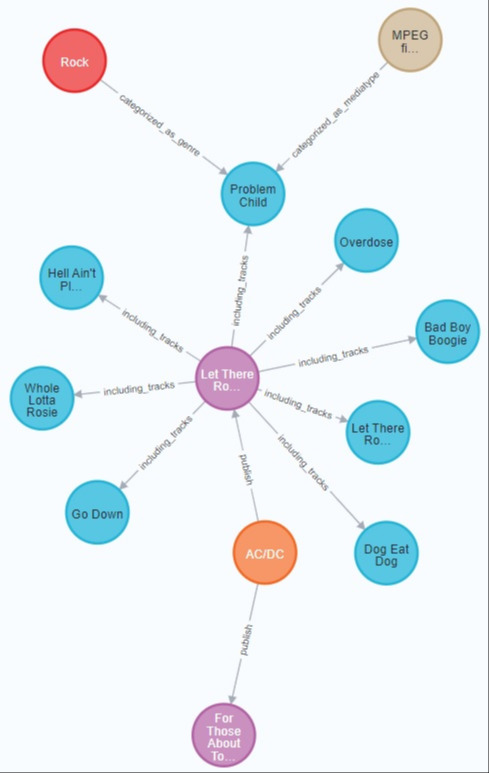</center>

# 3) Using Cypher to Retrieve Data from Neo4j

### __a) Write and execute a Cypher query that returns all Tracks from the ‘Jazz’ genre composed by ‘Miles Davis’__

__The following code finds the relationship "categorized_as_genre" between Track and Genre table. Specifying the condition in the property will generate the query result.__

MATCH(:Genre{Name:"Jazz"})-[:categorized_as_genre]->(a:Track{composer:"Miles Davis"}) RETURN a;

<center>
    <table>
        <tbody>
            <tr><td>"a"</td></tr>
            <tr><td>{"GId":"2","size":"11590284","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"48","time":"357459","ID":"602","Name":"'Round Midnight"}</td></tr>
            <tr><td>{"GId":"2","size":"6358868","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"197459","ID":"597","Name":"Now's The Time"}</td></tr>
            <tr><td>{"GId":"2","size":"17890773","price":"0.99","composer":"Miles Davis","AlId":"48","MId":"1","time":"544078","ID":"609","Name":"Someday My Prince Will Come"}</td></tr>
            <tr><td>{"GId":"2","size":"6273225","price":"0.99","composer":"Miles Davis","AlId":"49","MId":"1","time":"196101","ID":"615","Name":"Little Church (Live)"}</td></tr>
            <tr><td>{"GId":"2","size":"11254474","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"345025","ID":"599","Name":"Compulsion"}</td></tr>
            <tr><td>{"GId":"2","size":"18360449","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"564009","ID":"607","Name":"So What"}</td></tr>
            <tr><td>{"GId":"2","size":"7955114","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"49","time":"243461","ID":"617","Name":"Jean Pierre (Live)"}</td></tr>
            <tr><td>{"GId":"2","size":"27967919","price":"0.99","composer":"Miles Davis","AlId":"49","MId":"1","time":"843964","ID":"614","Name":"Miles Runs The Voodoo Down"}</td></tr>
            <tr><td>{"GId":"2","size":"10529483","composer":"Miles Davis","price":"0.99","AlId":"49","MId":"1","time":"316682","ID":"616","Name":"Black Satin"}</td></tr>
            <tr><td>{"GId":"2","size":"7548434","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"231784","ID":"600","Name":"Tempus Fugit"}</td></tr>
            <tr><td>{"GId":"2","size":"29416781","price":"0.99","composer":"Miles Davis","AlId":"49","MId":"1","time":"907520","ID":"610","Name":"My Funny Valentine (Live)"}</td></tr>
            <tr><td>{"GId":"2","size":"15549224","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"48","time":"476003","ID":"603","Name":"Bye Bye Blackbird"}</td></tr>
            <tr><td>{"GId":"2","size":"16131272","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"49","time":"487392","ID":"613","Name":"Petits Machins (Little Stuff)"}</td></tr>
            <tr><td>{"GId":"2","size":"7292197","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"49","time":"220734","ID":"618","Name":"Time After Time"}</td></tr>
            <tr><td>{"GId":"2","size":"26411634","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"807392","ID":"601","Name":"Walkin'"}</td></tr>
            <tr><td>{"GId":"2","size":"12520126","composer":"Miles Davis","price":"0.99","AlId":"49","MId":"1","time":"378775","ID":"619","Name":"Portia"}</td></tr>
            <tr><td>{"GId":"2","size":"9018024","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"277968","ID":"604","Name":"New Rhumba"}</td></tr>
            <tr><td>{"GId":"2","size":"15478450","composer":"Miles Davis","price":"0.99","AlId":"49","MId":"1","time":"473495","ID":"612","Name":"Nefertiti"}</td></tr>
            <tr><td>{"GId":"2","size":"7593713","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"233769","ID":"608","Name":"The Pan Piper"}</td></tr>
            <tr><td>{"GId":"2","size":"11079866","composer":"Miles Davis","price":"0.99","AlId":"49","MId":"1","time":"330684","ID":"611","Name":"E.S.P."}</td></tr>
            <tr><td>{"GId":"2","size":"5437017","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"168777","ID":"605","Name":"Generique"}</td></tr>
            <tr><td>{"GId":"2","size":"6461370","composer":"Miles Davis","price":"0.99","AlId":"48","MId":"1","time":"200437","ID":"606","Name":"Summertime"}</td></tr>
            <tr><td>{"GId":"2","size":"6222536","composer":"Miles Davis","price":"0.99","MId":"1","AlId":"48","time":"193410","ID":"598","Name":"Jeru"}</td></tr>
        </tbody>
    </table>
</center>

### __b) Write and execute a Cypher query that returns all Artists that have any Tracks available in the ‘AAC audio file’ media type.__

__The MediaType is directly related to Track. The Artist should link to MediaType and add the property selection in MediaType to query the result.__

MATCH(p:Artist)-[:publish]->(:Album)-[:including_tracks]->(:Track)<-[:categorized_as_mediatype]-(:MediaType{Name:"AAC audio file"}) RETURN p;

<center>
    <table>
        <tbody>
            <tr><td>"p"</td></tr>
            <tr><td>{"ID":"199","Name":"Karsh Kale"}</td></tr>
            <tr><td>{"ID":"197","Name":"Aisha Duo"}</td></tr>
            <tr><td>{"ID":"201","Name":"Luciana Souza/Romero Lubambo"}</td></tr>
            <tr><td>{"ID":"200","Name":"The Posies"}</td></tr>
            <tr><td>{"ID":"202","Name":"Aaron Goldberg"}</td></tr>
            <tr><td>{"ID":"198","Name":"Habib Koité and Bamada"}</td></tr>
            <tr><td>{"ID":"203","Name":"Nicolaus Esterhazy Sinfonia"}</td></tr>
            <tr><td>{"ID":"199","Name":"Karsh Kale"}</td></tr>
            <tr><td>{"ID":"198","Name":"Habib Koité and Bamada"}</td></tr>
            <tr><td>{"ID":"200","Name":"The Posies"}</td></tr>
            <tr><td>{"ID":"197","Name":"Aisha Duo"}</td></tr>
        </tbody>
    </table>
</center>

### __c) Write and execute a Cypher query that returns the Artist associated with the album ‘Bongo Fury’.__

__By selecting the property in Name in Album, we can query the result.__ 

MATCH(p:Artist)-[:publish]->(:Album{Name:"Bongo Fury"}) RETURN p;

<center>
    <table>
        <tbody>
            <tr><td>"p" </td></tr>
            <tr><td>{"ID":"23","Name":"Frank Zappa & Captain Beefheart"}</td></tr>
        </tbody>
    </table>
</center>

### __d) Write and execute a Cypher query that returns all Tracks from the album ‘Coda’ by the artist ‘Led Zeppelin’.__

__Match the relationship and the selection in each property, and specify the Track data to return__

MATCH(:Artist{Name:"Led Zeppelin"})-[:publish]->(:Album{Name:"Coda"})-[:including_tracks]->(t:Track) RETURN DISTINCT t;

<center>
    <table>
        <tbody>
            <tr><td>"t"</td></tr>
            <tr><td>{"GId":"1","size":"5180975","composer":"Ben E.King/James Bethea","price":"0.99","AlId":"128","MId":"1","time":"157570","ID":"1587","Name":"We're Gonna Groove"}</td></tr>
            <tr><td>{"GId":"1","size":"8557447","composer":"John Bonham","price":"0.99","MId":"1","AlId":"128","time":"258925","ID":"1593","Name":"Bonzo's Montreux"}</td></tr>
            <tr><td>{"GId":"1","size":"7079588","composer":"Jimmy Page, Robert Plant","price":"0.99","AlId":"128","MId":"1","time":"215954","ID":"1591","Name":"Ozone Baby"}</td></tr>
            <tr><td>{"GId":"1","size":"8437098","composer":"Willie Dixon","price":"0.99","MId":"1","AlId":"128","time":"258168","ID":"1589","Name":"I Can't Quit You Baby"}</td></tr>
            <tr><td>{"GId":"1","size":"10701590","composer":"Jimmy Page, Robert Plant","price":"0.99","AlId":"128","MId":"1","time":"330004","ID":"1594","Name":"Wearing And Tearing"}</td></tr>
            <tr><td>{"GId":"1","size":"10078197","price":"0.99","composer":"Jimmy Page, Robert Plant, John Bonham, John Paul Jones","MId":"1","AlId":"128","time":"307226","ID":"1592","Name":"Darlene"}</td></tr>
            <tr><td>{"GId":"1","size":"8712499","composer":"Jimmy Page, Robert Plant","price":"0.99","AlId":"128","MId":"1","time":"270785","ID":"1590","Name":"Walter's Walk"}</td></tr>
            <tr><td>{"GId":"1","size":"6016220","composer":"Jimmy Page/Robert Plant","price":"0.99","AlId":"128","MId":"1","time":"182491","ID":"1588","Name":"Poor Tom"}</td></tr>
        </tbody>
    </table>
</center>



### __e) Write and execute a Cypher query that returns all Albums that contain Tracks composed by ‘Alanis Morissette & Glenn Ballard’__

__Use the relationship between Album and Track and the property selection in composer__

MATCH(a:Album)-[:including_tracks]->(t:Track{composer:'Alanis Morissette & Glenn Ballard'}) RETURN DISTINCT a;

<center>
    <table>
        <tbody>
            <tr><td>"a"</td></tr>
            <tr><td>{"ArId":"4","ID":"6","Name":"Jagged Little Pill"}</td></tr>
        </tbody>
    </table>
</center>

### __f) Write and execute a Cypher query that returns the names of all Albums containing Tracks for which no Composer has been specified.__

__By using the IS NULL to select the track that have null value in composer. The relationship between Album and Track is used to return the Album data.__ 

MATCH(r:Album)-[:including_tracks]->(t:Track) WHERE t.composer IS NULL RETURN DISTINCT r;

<center>
    <table>
        <tbody>
            <tr><td>{"ArId":"2","ID":"2","Name":"Balls to the Wall"}</td></tr>
            <tr><td>{"ArId":"6","ID":"8","Name":"Warner 25 Anos"}</td></tr>
            <tr><td>{"ArId":"11","ID":"14","Name":"Alcohol Fueled Brewtality Live! [Disc 1]"}</td></tr>
            <tr><td>{"ArId":"11","ID":"15","Name":"Alcohol Fueled Brewtality Live! [Disc 2]"} </td></tr>
            <tr><td>{"ArId":"12","ID":"16","Name":"Black Sabbath"}</td></tr>
            <tr><td>{"ArId":"13","ID":"18","Name":"Body Count"}</td></tr>
            <tr><td>{"ArId":"16","ID":"22","Name":"Sozinho Remix Ao Vivo"}</td></tr>
            <tr><td>{"ArId":"17","ID":"23","Name":"Minha Historia"}</td></tr>
            <tr><td>{"ArId":"18","ID":"25","Name":"Da Lama Ao Caos"}</td></tr>
            <tr><td>{"ArId":"20","ID":"28","Name":"Na Pista"}</td></tr>
            <tr><td>{"ArId":"21","ID":"32","Name":"Carnaval 2001"}</td></tr>
            <tr><td>{"ArId":"53","ID":"38","Name":"Heart of the Night"}</td></tr>
            <tr><td>{"ArId":"56","ID":"41","Name":"Meus Momentos"}</td></tr>
            <tr><td>{"ArId":"37","ID":"47","Name":"The Best of Ed Motta"}</td></tr>
            <tr><td>{"ArId":"69","ID":"51","Name":"Up An' Atom"}</td></tr>
            <tr><td>{"ArId":"70","ID":"52","Name":"Vinícius De Moraes - Sem Limite"}</td></tr>
            <tr><td>{"ArId":"21","ID":"53","Name":"Vozes do MPB"}</td></tr>
            <tr><td>{"ArId":"77","ID":"56","Name":"Cássia Eller - Coleção Sem Limite [Disc 2]"}</td></tr>
            <tr><td>{"ArId":"77","ID":"57","Name":"Cássia Eller - Sem Limite [Disc 1]"}</td></tr>
            <tr><td>{"ArId":"78","ID":"67","Name":"Vault: Def Leppard's Greatest Hits"}</td></tr>
            <tr><td>{"ArId":"80","ID":"69","Name":"Djavan Ao Vivo - Vol. 02"}</td></tr>
            <tr><td>{"ArId":"41","ID":"71","Name":"Elis Regina-Minha História"}</td></tr>
            <tr><td>{"ArId":"82","ID":"75","Name":"Angel Dust"}</td></tr>
            <tr><td>{"ArId":"83","ID":"78","Name":"Deixa Entrar"}</td></tr>
            <tr><td>{"ArId":"86","ID":"84","Name":"Roda De Funk"}</td></tr>
            <tr><td>{"ArId":"27","ID":"85","Name":"As Canções de Eu Tu Eles"}</td></tr>
            <tr><td>{"ArId":"27","ID":"86","Name":"Quanta Gente Veio Ver (Live)"}</td></tr>
            <tr><td>{"ArId":"27","ID":"87","Name":"Quanta Gente Veio ver--Bônus De Carnaval"}</td></tr>
            <tr><td>{"ArId":"88","ID":"90","Name":"Appetite for Destruction"}</td></tr>
            <tr><td>{"ArId":"88","ID":"91","Name":"Use Your Illusion I"}</td></tr>
            <tr><td>{"ArId":"90","ID":"94","Name":"A Matter of Life and Death"}</td></tr>
            <tr><td>{"ArId":"90","ID":"102","Name":"Live After Death"}</td></tr>
            <tr><td>{"ArId":"90","ID":"103","Name":"Live At Donington 1992 (Disc 1)"}</td></tr>
            <tr><td>{"ArId":"90","ID":"104","Name":"Live At Donington 1992 (Disc 2)"}</td></tr>
            <tr><td>{"ArId":"90","ID":"108","Name":"Rock In Rio [CD1]"}</td></tr>
            <tr><td>{"ArId":"95","ID":"121","Name":"Surfing with the Alien (Remastered)"}</td></tr>
            <tr><td>{"ArId":"46","ID":"122","Name":"Jorge Ben Jor 25 Anos"}</td></tr>
            <tr><td>{"ArId":"96","ID":"123","Name":"Jota Quest-1995"}</td></tr>
            <tr><td>{"ArId":"98","ID":"125","Name":"Living After Midnight"}</td></tr>
            <tr><td>{"ArId":"100","ID":"141","Name":"Greatest Hits"}</td></tr>
            <tr><td>{"ArId":"101","ID":"142","Name":"Lulu Santos - RCA 100 Anos De Música - Álbum 01"}</td></tr>
            <tr><td>{"ArId":"101","ID":"143","Name":"Lulu Santos - RCA 100 Anos De Música - Álbum 02"}</td></tr>
            <tr><td>{"ArId":"104","ID":"146","Name":"Seek And Shall Find: More Of The Best (1963-1981)"}</td></tr>
            <tr><td>{"ArId":"105","ID":"147","Name":"The Best Of Men At Work"}</td></tr>
            <tr><td>{"ArId":"111","ID":"165","Name":"Compositores"}</td></tr>
            <tr><td>{"ArId":"112","ID":"166","Name":"Olodum"}</td></tr>
            <tr><td>{"ArId":"113","ID":"169","Name":"Arquivo Os Paralamas Do Sucesso"}</td></tr>
            <tr><td>{"ArId":"121","ID":"184","Name":"Os Cães Ladram Mas A Caravana Não Pára"}</td></tr>
            <tr><td>{"ArId":"126","ID":"192","Name":"Raul Seixas"}</td></tr>
            <tr><td>{"ArId":"59","ID":"198","Name":"Santana Live"}</td></tr>
            <tr><td>{"ArId":"139","ID":"213","Name":"Pure Cult: The Best Of The Cult (For Rockers, Ravers, Lovers & Sinners) [UK]"}</td></tr>
            <tr><td>{"ArId":"145","ID":"223","Name":"Serie Sem Limite (Disc 2)"}</td></tr>
            <tr><td>{"ArId":"147","ID":"226","Name":"Battlestar Galactica: The Story So Far"}</td></tr>
            <tr><td>{"ArId":"147","ID":"227","Name":"Battlestar Galactica, Season 3"}</td></tr>
            <tr><td>{"ArId":"148","ID":"228","Name":"Heroes, Season 1"}</td></tr>
            <tr><td>{"ArId":"149","ID":"229","Name":"Lost, Season 3"}</td></tr>
            <tr><td>{"ArId":"149","ID":"230","Name":"Lost, Season 1"}</td></tr>
            <tr><td>{"ArId":"149","ID":"231","Name":"Lost, Season 2"}</td></tr>
            <tr><td>{"ArId":"151","ID":"241","Name":"UB40 The Best Of - Volume Two [UK]"}</td></tr>
            <tr><td>{"ArId":"72","ID":"247","Name":"Vinicius De Moraes"}</td></tr>
            <tr><td>{"ArId":"156","ID":"249","Name":"The Office, Season 1"}</td></tr>
            <tr><td>{"ArId":"156","ID":"250","Name":"The Office, Season 2"}</td></tr>
            <tr><td>{"ArId":"156","ID":"251","Name":"The Office, Season 3"}</td></tr>
            <tr><td>{"ArId":"158","ID":"253","Name":"Battlestar Galactica (Classic), Season 1"}</td></tr>
            <tr><td>{"ArId":"159","ID":"254","Name":"Aquaman"}</td></tr>
            <tr><td>{"ArId":"150","ID":"255","Name":"Instant Karma: The Amnesty International Campaign to Save Darfur"}</td></tr>
            <tr><td>{"ArId":"114","ID":"256","Name":"Speak of the Devil"}</td></tr>
            <tr><td>{"ArId":"179","ID":"257","Name":"20th Century Masters - The Millennium Collection: The Best of Scorpions"}</td></tr>
            <tr><td>{"ArId":"36","ID":"259","Name":"Radio Brasil (O Som da Jovem Vanguarda) - Seleccao de Henrique Amaro"}</td></tr>
            <tr><td>{"ArId":"196","ID":"260","Name":"Cake: B-Sides and Rarities"}</td></tr>
            <tr><td>{"ArId":"149","ID":"261","Name":"LOST, Season 4"}</td></tr>
            <tr><td>{"ArId":"204","ID":"269","Name":"Temple of the Dog"}</td></tr>
            <tr><td>{"ArId":"8","ID":"271","Name":"Revelations"}</td></tr>
            <tr><td>{"ArId":"245","ID":"310","Name":"Prokofiev: Romeo & Juliet"}</td></tr>
            <tr><td>{"ArId":"250","ID":"318","Name":"SCRIABIN: Vers la flamme"}</td></tr>
            <tr><td>{"ArId":"252","ID":"321","Name":"Back to Black"}</td></tr>
            <tr><td>{"ArId":"252","ID":"322","Name":"Frank"}</td></tr>
            <tr><td>{"ArId":"253","ID":"323","Name":"Carried to Dust (Bonus Track Version)"}</td></tr>
            <tr><td>{"ArId":"256","ID":"326","Name":"Mendelssohn: A Midsummer Night's Dream"}</td></tr>
            <tr><td>{"ArId":"269","ID":"340","Name":"Liszt - 12 Études D'Execution Transcendante"}</td></tr>
            <tr><td>{"ArId":"270","ID":"341","Name":"Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder"}</td></tr>
            <tr><td>{"ArId":"226","ID":"343","Name":"Respighi:Pines of Rome"}</td></tr>
        </tbody>
    </table>
</center>

# Ref:
* https://community.neo4j.com/t5/neo4j-graph-platform/creating-relationships-and-querying-data-across-multiple-nodes/td-p/29015
* https://neo4j.com/docs/cypher-manual/current/syntax/working-with-null/